Using Python 3 Kernel

In [2]:
%matplotlib inline
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from fiona.crs import from_epsg
from geopandas.tools import overlay

In [3]:
#Function for overlay
def spatial_overlays(df1, df2, how='intersection', reproject=True):
    """Perform spatial overlay between two polygons.

    Currently only supports data GeoDataFrames with polygons.
    Implements several methods that are all effectively subsets of
    the union.

    Parameters
    ----------
    df1 : GeoDataFrame with MultiPolygon or Polygon geometry column
    df2 : GeoDataFrame with MultiPolygon or Polygon geometry column
    how : string
        Method of spatial overlay: 'intersection', 'union',
        'identity', 'symmetric_difference' or 'difference'.
    use_sindex : boolean, default True
        Use the spatial index to speed up operation if available.

    Returns
    -------
    df : GeoDataFrame
        GeoDataFrame with new set of polygons and attributes
        resulting from the overlay

    """
    from functools import reduce
    df1 = df1.copy()
    df2 = df2.copy()
    df1['geometry'] = df1.geometry.buffer(0)
    df2['geometry'] = df2.geometry.buffer(0)
    if df1.crs!=df2.crs and reproject:
        print('Data has different projections.')
        print('Converted data to projection of first GeoPandas DatFrame')
        df2.to_crs(crs=df1.crs, inplace=True)
    if how=='intersection':
        # Spatial Index to create intersections
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['sidx']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        pairs = df1['sidx'].to_dict()
        nei = []
        for i,j in pairs.items():
            for k in j:
                nei.append([i,k])
        pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
        pairs = pairs.merge(df1, left_on='idx1', right_index=True)
        pairs = pairs.merge(df2, left_on='idx2', right_index=True, suffixes=['_1','_2'])
        pairs['Intersection'] = pairs.apply(lambda x: (x['geometry_1'].intersection(x['geometry_2'])).buffer(0), axis=1)
        pairs = gpd.GeoDataFrame(pairs, columns=pairs.columns, crs=df1.crs)
        cols = pairs.columns.tolist()
        cols.remove('geometry_1')
        cols.remove('geometry_2')
        cols.remove('sidx')
        cols.remove('bbox')
        cols.remove('Intersection')
        dfinter = pairs[cols+['Intersection']].copy()
        dfinter.rename(columns={'Intersection':'geometry'}, inplace=True)
        dfinter = gpd.GeoDataFrame(dfinter, columns=dfinter.columns, crs=pairs.crs)
        dfinter = dfinter.loc[dfinter.geometry.is_empty==False]
        dfinter.drop(['idx1','idx2'], inplace=True, axis=1)
        return dfinter
    elif how=='difference':
        spatial_index = df2.sindex
        df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
        df1['sidx']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        df1['new_g'] = df1.apply(lambda x: reduce(lambda x, y: x.difference(y).buffer(0), 
                                 [x.geometry]+list(df2.iloc[x.sidx].geometry)) , axis=1)
        df1.geometry = df1.new_g
        df1 = df1.loc[df1.geometry.is_empty==False].copy()
        df1.drop(['bbox', 'sidx', 'new_g'], axis=1, inplace=True)
        return df1
    elif how=='symmetric_difference':
        df1['idx1'] = df1.index.tolist()
        df2['idx2'] = df2.index.tolist()
        df1['idx2'] = np.nan
        df2['idx1'] = np.nan
        dfsym = df1.merge(df2, on=['idx1','idx2'], how='outer', suffixes=['_1','_2'])
        dfsym['geometry'] = dfsym.geometry_1
        dfsym.loc[dfsym.geometry_2.isnull()==False, 'geometry'] = dfsym.loc[dfsym.geometry_2.isnull()==False, 'geometry_2']
        dfsym.drop(['geometry_1', 'geometry_2'], axis=1, inplace=True)
        dfsym = gpd.GeoDataFrame(dfsym, columns=dfsym.columns, crs=df1.crs)
        spatial_index = dfsym.sindex
        dfsym['bbox'] = dfsym.geometry.apply(lambda x: x.bounds)
        dfsym['sidx'] = dfsym.bbox.apply(lambda x:list(spatial_index.intersection(x)))
        dfsym['idx'] = dfsym.index.values
        dfsym.apply(lambda x: x.sidx.remove(x.idx), axis=1)
        dfsym['new_g'] = dfsym.apply(lambda x: reduce(lambda x, y: x.difference(y).buffer(0), 
                         [x.geometry]+list(dfsym.iloc[x.sidx].geometry)) , axis=1)
        dfsym.geometry = dfsym.new_g
        dfsym = dfsym.loc[dfsym.geometry.is_empty==False].copy()
        dfsym.drop(['bbox', 'sidx', 'idx', 'idx1','idx2', 'new_g'], axis=1, inplace=True)
        return dfsym
    elif how=='union':
        dfinter = spatial_overlays(df1, df2, how='intersection')
        dfsym = spatial_overlays(df1, df2, how='symmetric_difference')
        dfunion = dfinter.append(dfsym)
        dfunion.reset_index(inplace=True, drop=True)
        return dfunion
    elif how=='identity':
        dfunion = spatial_overlays(df1, df2, how='union')
        cols1 = df1.columns.tolist()
        cols2 = df2.columns.tolist()
        cols1.remove('geometry')
        cols2.remove('geometry')
        cols2 = set(cols2).intersection(set(cols1))
        cols1 = list(set(cols1).difference(set(cols2)))
        cols2 = [col+'_1' for col in cols2]
        dfunion = dfunion[(dfunion[cols1+cols2].isnull()==False).values]
        return dfunion

In [4]:
#function for download data from egis3
def download_egis3(url, zipname, folder, shpname):
    #take in download url, downloaded zipfile name, folder name
    #containing unzipped shapefile, shapefile name
    #return the downloaded geodataframe
    os.system("curl -O " + url)
    os.system("unzip " + zipname + " -d " + folder)
    
    df = folder
    df = gpd.read_file(folder + "/" + shpname)

    df.crs = from_epsg(2229)
    df = df.to_crs(epsg=4326)
    return df

In [5]:
#function for reading downloaded census data from Census Bureau
def read_census(zipname, folder, shpname):
    os.system("curl -O " + url)
    os.system("unzip " + zipname + " -d " + folder)
    
    df = folder
    df = gpd.read_file(folder + "/" + shpname)

    return df 

In [6]:
#function to check the data quality
def checkdf(dfname):
    #take in geodataframe
    #return number of null values and unique values
    tota_poly = dfname.shape[0]
    print ('Total polygon number: {}'.format(tota_poly))    
    print ('number of null and unique values in each column:')
    
    for i in dfname.columns[:-1]:
        tota_valu = dfname.count()[i]
        null_valu = tota_poly - tota_valu
        uniq_valu = len(dfname[i].unique())
        print ('{}: null {}, unique {}'.format(i, null_valu, uniq_valu))
    return dfname.head(3)

In [7]:
#function to drop redundant columns
def cleandf(dfname, droplist):
    #take in geodataframe and list of column name redundant
    #return the clean df
    notneedlist = ['OBJECTID', 'Shape_area', 'Shape_len']
    
    for i in dfname.columns[:-1]:
        if i in notneedlist:
            dfname.drop([i], axis=1, inplace=True)
            
    for i in droplist:
        dfname.drop([i], axis=1, inplace=True)
    
    return dfname.head(3)

## Data inspection

#### We inspected the following 20 geometries:
- .[Health Districts (HD) – 2012](http://egis3.lacounty.gov/dataportal/2012/03/01/health-districts-hd-2012/)
- ..[Law Enforcement Reporting Districts](https://egis3.lacounty.gov/dataportal/2010/10/05/law-enforcement-reporting-districts/)
- ..[School District Boundaries (2011)](http://egis3.lacounty.gov/dataportal/2012/01/20/school-district-boundaries-2011/)
- .[California State Senate Districts (2011)](http://egis3.lacounty.gov/dataportal/2011/11/08/california-state-senate-districts-2011/)
- .[US Congressional Districts](http://egis3.lacounty.gov/dataportal/2010/01/14/us-congressional-districts/)
- .[ZIP Code Boundaries](https://egis3.lacounty.gov/dataportal/2016/08/11/zip-codes-with-parcel-specific-boundaries/)
- .[Public Use Microdata Areas (PUMA)](https://www2.census.gov/geo/tiger/GENZ2016/shp/)
- ..[LAcounty_COMMUNITIES](https://egis3.lacounty.gov/dataportal/2010/10/21/citycommunity-boundaries/)
- [Split 2010 Block Group/City – Community Statistical Area (formerly BASA)](https://egis3.lacounty.gov/dataportal/2016/01/18/split-2010-block-groupcity-basa/)
- [Town Council / Community Group](https://egis3.lacounty.gov/dataportal/2014/12/29/town-council-areas/)
- [Los Angeles County Fire Department Division Boundaries](http://egis3.lacounty.gov/dataportal/2016/04/28/los-angeles-county-fire-department-division-boundaties/)
- [Los Angeles County Fire Department Battalion Boundaries](http://egis3.lacounty.gov/dataportal/2016/04/28/los-angeles-county-fire-department-battalion-boundaries/)
- .[2011 Supervisorial District Boundaries (Official)](http://egis3.lacounty.gov/dataportal/2011/12/06/supervisorial-districts/)
- [LA City Council Districts (2012)](http://egis3.lacounty.gov/dataportal/2012/08/07/la-city-council-districts-2012/)
- .[State Assembly Districts (State Legislative District – Lower Chamber)](http://egis3.lacounty.gov/dataportal/2011/11/08/california-state-assembly-districts-2011/)
- ..[Registrar Recorder Precincts](https://egis3.lacounty.gov/dataportal/2012/12/20/2012-precincts-as-of-march-9th/)
- [Comunity Plan Areas](http://egis3.lacounty.gov/dataportal/2015/09/21/la-city-communities-and-planning-areas/)
- [CDC Project Areas](https://egis3.lacounty.gov/dataportal/2015/06/09/cdc-project-areas/)
- .[Census Tract](http://egis3.lacounty.gov/dataportal/2016/01/26/census_tracts/)
- ..[Census Block](http://egis3.lacounty.gov/dataportal/2016/01/26/census_blocks/)

In [8]:
dfname_list = []

In [9]:
#Health Districts (HD) – 2012
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/2012/" \
      "02/HD_20121.zip"
health_districts = download_egis3(url, 'HD_20121.zip', 'health_districts', 'Health_Districts_2012.shp')
dfname_list.append('health_districts')

checkdf(health_districts)

Total polygon number: 26
number of null and unique values in each column:
OBJECTID: null 0, unique 26
HD_NAME: null 0, unique 26
SPA_NAME: null 0, unique 8
Shape_area: null 0, unique 26
Shape_len: null 0, unique 26
HD_2012: null 0, unique 26
SPA_2012: null 0, unique 8


,OBJECTID,HD_NAME,SPA_NAME,Shape_area,Shape_len,HD_2012,SPA_2012,geometry
0,1,Alhambra,San Gabriel,1.089719e+09,2.018927e+05,3,3,"POLYGON ((-118.0942930008 34.13524499950874, -..."
1,2,Antelope Valley,Antelope Valley,3.859238e+10,1.484948e+06,5,1,POLYGON ((-117.6552358399884 34.39722196554607...
2,3,Bellflower,East,1.086595e+09,2.620187e+05,6,7,(POLYGON ((-118.0287288746297 33.8733158131870...


In [10]:
droplist = ['SPA_NAME', 'SPA_2012']
cleandf(health_districts, droplist)

,HD_NAME,HD_2012,geometry
0,Alhambra,3,"POLYGON ((-118.0942930008 34.13524499950874, -..."
1,Antelope Valley,5,POLYGON ((-117.6552358399884 34.39722196554607...
2,Bellflower,6,(POLYGON ((-118.0287288746297 33.8733158131870...


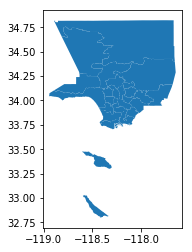

In [11]:
health_districts.plot()

In [12]:
#Law Enforcement Reporting Districts
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/" \
      "ShapefilePackages/LACOUNTY_LAW_ENFORCEMENT_RDs.zip"
law_enforcement = download_egis3(url, 'LACOUNTY_LAW_ENFORCEMENT_RDs.zip', 'law_enforcement', 'LACOUNTY_LAW_ENFORCEMENT_RDs.shp')
dfname_list.append('law_enforcement')
checkdf(law_enforcement)

Total polygon number: 5745
number of null and unique values in each column:
RD: null 0, unique 3667
Name: null 0, unique 519
Layer: null 0, unique 3


,RD,Name,Layer,geometry
0,0230,Belvedere,Parks Bureau,POLYGON ((-118.1604325432619 34.03712079823092...
1,0231,Atlantic Avenue,Parks Bureau,"POLYGON ((-118.1550797745909 34.0257529106941,..."
2,0232,City Terrace,Parks Bureau,POLYGON ((-118.1784888821586 34.04781649689102...


In [13]:
droplist = ['Layer']
cleandf(law_enforcement, droplist)

,RD,Name,geometry
0,0230,Belvedere,POLYGON ((-118.1604325432619 34.03712079823092...
1,0231,Atlantic Avenue,"POLYGON ((-118.1550797745909 34.0257529106941,..."
2,0232,City Terrace,POLYGON ((-118.1784888821586 34.04781649689102...


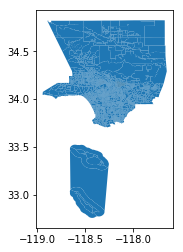

In [14]:
law_enforcement.plot()

In [15]:
#School District Boundaries (2011)
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/2012/01/" \
      "rrcc_school_districts1.zip"
school_districts = download_egis3(url, 'rrcc_school_districts1.zip', 'school_districts', 'rrcc_school_districts.shp')
dfname_list.append('school_districts')
checkdf(school_districts)

Total polygon number: 79
number of null and unique values in each column:
DISTRICT: null 0, unique 78
UNIFIED: null 0, unique 49
HIGH: null 0, unique 9
ELEMENTARY: null 0, unique 31
PH: null 0, unique 78
ADDR: null 0, unique 78
PH2: null 0, unique 20
PH3: null 0, unique 6
STU: null 0, unique 78
HI_ADDR: null 0, unique 9
HI_PH: null 0, unique 9
HI_STU: null 0, unique 9
LABEL: null 0, unique 78


,DISTRICT,UNIFIED,HIGH,ELEMENTARY,PH,ADDR,PH2,PH3,STU,HI_ADDR,HI_PH,HI_STU,LABEL,geometry
0,HERMOSA BEACH CITY ELEMENTARY,,,HERMOSA BEACH CITY ELEMENTARY,310 937 5877,1645 VALLEY DR HERMOSA BCH 90254,,,950,,,,HERMOSA BEACH CITY ELEM,POLYGON ((-118.4048577253546 33.87782346394338...
1,CENTINELA VALLEY UNION HIGH/HAWTHORNE ELEMENTARY,,CENTINELA VALLEY UNION HIGH,HAWTHORNE ELEMENTARY,310 676 2276,14120 S HAWTHORNE BL HAWTHORNE 90250,,,8145,14901 S INGLEWOOD AV LAWNDALE 90260,310 263 3200,6220,CENTINELA VALLEY UNION HIGH\nHAWTHORNE ELEMENTARY,POLYGON ((-118.3607054443706 33.93093449396304...
2,CENTINELA VALLEY UNION HIGH/LAWNDALE ELEMENTARY,,CENTINELA VALLEY UNION HIGH,LAWNDALE ELEMENTARY,310 973 1300,4161 W 147TH ST LAWNDALE 90260,,,5510,14901 S INGLEWOOD AV LAWNDALE 90260,310 263 3200,6220,CENTINELA VALLEY UNION HIGH\nLAWNDALE ELEMENTARY,"POLYGON ((-118.367294562588 33.90558198783078,..."


In [16]:
droplist = ['UNIFIED', 'HIGH', 'ELEMENTARY', 'PH', 'ADDR', 'PH2', 'PH3',
       'STU', 'HI_ADDR', 'HI_PH', 'HI_STU', 'LABEL']
cleandf(school_districts, droplist)

,DISTRICT,geometry
0,HERMOSA BEACH CITY ELEMENTARY,POLYGON ((-118.4048577253546 33.87782346394338...
1,CENTINELA VALLEY UNION HIGH/HAWTHORNE ELEMENTARY,POLYGON ((-118.3607054443706 33.93093449396304...
2,CENTINELA VALLEY UNION HIGH/LAWNDALE ELEMENTARY,"POLYGON ((-118.367294562588 33.90558198783078,..."


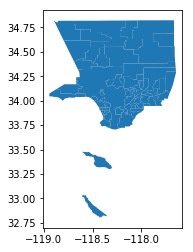

In [17]:
school_districts.plot()

In [18]:
#California State Senate Districts (2011)
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/2011/11/" \
      "state-senate-2011.zip"
state_senate = download_egis3(url, 'state-senate-2011.zip', 'state_senate', 'senate.shp')
dfname_list.append('state_senate')
checkdf(state_senate)

Total polygon number: 16
number of null and unique values in each column:
DISTRICT: null 0, unique 16
NAME: null 0, unique 16
LABEL: null 0, unique 16


,DISTRICT,NAME,LABEL,geometry
0,16,TULKE,Disrict 16,POLYGON ((-117.6671490011134 34.75005899908675...
1,18,LASFE,Disrict 18,POLYGON ((-118.3611510010984 34.19465099908038...
2,20,POMSB,Disrict 20,POLYGON ((-117.7676900009356 34.02350599909427...


In [19]:
droplist = ['LABEL']
cleandf(state_senate, droplist)

,DISTRICT,NAME,geometry
0,16,TULKE,POLYGON ((-117.6671490011134 34.75005899908675...
1,18,LASFE,POLYGON ((-118.3611510010984 34.19465099908038...
2,20,POMSB,POLYGON ((-117.7676900009356 34.02350599909427...


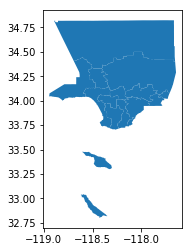

In [20]:
state_senate.plot()

In [21]:
#US Congressional Districts
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/" \
      "ShapefilePackages/RRCC_CONGRESSIONAL_DISTRICTS.zip"
congressional_districts = download_egis3(url, 'RRCC_CONGRESSIONAL_DISTRICTS.zip', 'congressional_districts', 'RRCC_CONGRESSIONAL_DISTRICTS.shp')
dfname_list.append('congressional_districts')
checkdf(congressional_districts)

Total polygon number: 18
number of null and unique values in each column:
DIST_CONG: null 0, unique 18
Shape_area: null 0, unique 18
Shape_len: null 0, unique 18


,DIST_CONG,Shape_area,Shape_len,geometry
0,23,5.447776e+09,4.986277e+05,POLYGON ((-117.7736888188639 34.82248828448963...
1,25,4.598790e+10,1.449675e+06,(POLYGON ((-117.7668535002114 34.8232750430814...
2,26,1.535730e+08,6.420494e+04,POLYGON ((-118.7888893009787 34.16821405941698...


In [22]:
droplist = []
cleandf(congressional_districts, droplist)

,DIST_CONG,geometry
0,23,POLYGON ((-117.7736888188639 34.82248828448963...
1,25,(POLYGON ((-117.7668535002114 34.8232750430814...
2,26,POLYGON ((-118.7888893009787 34.16821405941698...


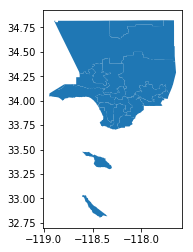

In [23]:
congressional_districts.plot()

In [24]:
#ZIP Code Boundaries
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/2011/01/" \
      "CAMS_ZIPCODE_PARCEL_SPECIFIC.zip"
zip_code = download_egis3(url, 'CAMS_ZIPCODE_PARCEL_SPECIFIC.zip', 'zip_code', 'CAMS_ZIPCODE_PARCEL_SPECIFIC.shp')
dfname_list.append('zip_code')
checkdf(zip_code)

Total polygon number: 311
number of null and unique values in each column:
OBJECTID: null 0, unique 311
ZIPCODE: null 0, unique 311
Shape_area: null 0, unique 311
Shape_len: null 0, unique 311


,OBJECTID,ZIPCODE,Shape_area,Shape_len,geometry
0,1,90001,9.556340e+07,48677.278478,POLYGON ((-118.2433683541707 33.98923126419061...
1,2,90002,8.275222e+07,44972.017035,"POLYGON ((-118.2342946311994 33.9610050725129,..."
2,3,90003,1.026431e+08,63303.481758,POLYGON ((-118.2828356317466 33.97596170409104...


In [25]:
droplist = []
cleandf(zip_code, droplist)

,ZIPCODE,geometry
0,90001,POLYGON ((-118.2433683541707 33.98923126419061...
1,90002,"POLYGON ((-118.2342946311994 33.9610050725129,..."
2,90003,POLYGON ((-118.2828356317466 33.97596170409104...


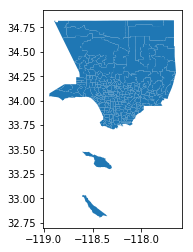

In [26]:
zip_code.plot()

In [27]:
#PUMA
!wget http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_06_puma10_500k.zip
puma = read_census('cb_2016_06_puma10_500k.zip', 'puma', 'cb_2016_06_puma10_500k.shp')
dfname_list.append('puma')
checkdf(puma)

URL transformed to HTTPS due to an HSTS policy
--2018-01-05 23:37:32--  https://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_06_puma10_500k.zip
Resolving www2.census.gov... 2600:1408:24:599::208c, 2600:1408:24:5aa::208c, 104.121.83.95
Connecting to www2.census.gov|2600:1408:24:599::208c|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 742516 (725K) [application/zip]
Saving to: 'cb_2016_06_puma10_500k.zip.2'

cb_2016_06_puma10_5 100%[===================>] 725.11K  2.63MB/s    in 0.3s    

2018-01-05 23:37:33 (2.63 MB/s) - 'cb_2016_06_puma10_500k.zip.2' saved [742516/742516]

Total polygon number: 265
number of null and unique values in each column:
STATEFP10: null 0, unique 1
PUMACE10: null 0, unique 265
AFFGEOID10: null 0, unique 265
GEOID10: null 0, unique 265
NAME10: null 0, unique 265
LSAD10: null 0, unique 1
ALAND10: null 0, unique 265
AWATER10: null 0, unique 254


,STATEFP10,PUMACE10,AFFGEOID10,GEOID10,NAME10,LSAD10,ALAND10,AWATER10,geometry
0,06,01907,7950000US0601907,0601907,"Fresno County (East)--Sanger, Reedley & Parlie...",P0,7647644973,117294872,"POLYGON ((-119.745652 36.938998, -119.743741 3..."
1,06,00702,7950000US0600702,0600702,Butte County (Southeast)--Oroville City & Para...,P0,2918880948,94035819,"POLYGON ((-121.908697 39.30799, -121.907403 39..."
2,06,07307,7950000US0607307,0607307,"San Diego County (Central)--Lakeside, Winter G...",P0,632518078,8339612,"POLYGON ((-116.993347 32.892625, -116.993058 3..."


In [28]:
droplist = ['STATEFP10', 'AFFGEOID10', 'GEOID10', 'LSAD10',
       'ALAND10', 'AWATER10']
cleandf(puma, droplist)

,PUMACE10,NAME10,geometry
0,01907,"Fresno County (East)--Sanger, Reedley & Parlie...","POLYGON ((-119.745652 36.938998, -119.743741 3..."
1,00702,Butte County (Southeast)--Oroville City & Para...,"POLYGON ((-121.908697 39.30799, -121.907403 39..."
2,07307,"San Diego County (Central)--Lakeside, Winter G...","POLYGON ((-116.993347 32.892625, -116.993058 3..."


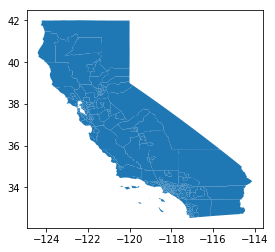

In [29]:
puma.plot()

In [30]:
# LAcounty_COMMUNITIES
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/2010/10/" \
      "Communities1.zip"
county_communities = download_egis3(url, 'Communities1.zip', 'county_communities', 'Communities.shp')
dfname_list.append('county_communities')
checkdf(county_communities)

Total polygon number: 353
number of null and unique values in each column:
COMMTYPE: null 0, unique 3
NAME: null 0, unique 206
COLOR: null 0, unique 7
PO_NAME: null 0, unique 177
STATNAME: null 0, unique 193
X_CENTER: null 0, unique 353
Y_CENTER: null 0, unique 353
ST_NAME: null 0, unique 88
LABEL_CITY: null 0, unique 89
LABEL_COMM: null 0, unique 143
AREA_SQMI: null 0, unique 322
Shape_area: null 0, unique 353
Shape_len: null 0, unique 353


,COMMTYPE,NAME,COLOR,PO_NAME,STATNAME,X_CENTER,Y_CENTER,ST_NAME,LABEL_CITY,LABEL_COMM,AREA_SQMI,Shape_area,Shape_len,geometry
0,Unincorporated,Edwards,Yellow,Edwards,East Antelope Valley,6590507,2111007,Lancaster,Unincorporated,Edwards,93.961,2.619470e+09,337914.985138,POLYGON ((-118.1407088589749 34.81827748625132...
1,Unincorporated,Gorman,Yellow,West Antelope Valley,West Antelope Valley,6357449,2089258,Santa Clarita Valley,Unincorporated,Gorman,173.752,4.843936e+09,442757.717076,POLYGON ((-118.4662754936974 34.81837563424517...
2,Unincorporated,Del Sur,Yellow,Lancaster,Quartz Hill,6469031,2091460,Lancaster,Unincorporated,Del Sur,135.398,3.774671e+09,423904.059503,POLYGON ((-118.4662754936974 34.81837563424517...


In [31]:
droplist = ['COMMTYPE', 'COLOR', 'PO_NAME', 'STATNAME', 'X_CENTER',
       'Y_CENTER', 'ST_NAME', 'LABEL_CITY', 'LABEL_COMM', 'AREA_SQMI']
cleandf(county_communities, droplist)

,NAME,geometry
0,Edwards,POLYGON ((-118.1407088589749 34.81827748625132...
1,Gorman,POLYGON ((-118.4662754936974 34.81837563424517...
2,Del Sur,POLYGON ((-118.4662754936974 34.81837563424517...


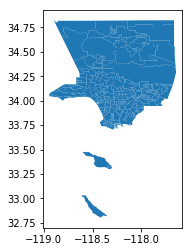

In [32]:
county_communities.plot()

In [33]:
#Split 2010 Block Group/City – Community Statistical Area (formerly BASA)
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/2015/12/" \
      "EGIS_BG10FIPxx_CSA_20170118.zip"
community_stat_area = download_egis3(url, 'EGIS_BG10FIPxx_CSA_20170118.zip', 'community_stat_area', 'EGIS_BG10FIPxx_CSA_20170118.shp')
dfname_list.append('community_stat_area')
checkdf(community_stat_area)

Total polygon number: 7137
number of null and unique values in each column:
OBJECTID: null 0, unique 7137
BG10: null 0, unique 6422
CT10: null 0, unique 2344
FIP10: null 0, unique 89
FIP11: null 0, unique 89
FIP12: null 0, unique 89
FIP13: null 0, unique 89
FIP14: null 0, unique 89
FIP15: null 0, unique 89
FIP16: null 0, unique 89
CITY_TYPE: null 0, unique 2
LCITY: null 0, unique 89
BASA: null 0, unique 257
LABEL: null 0, unique 348
SOURCE: null 0, unique 2
BG10FIP10: null 0, unique 6882
BG10FIP11: null 0, unique 6882
BG10FIP12: null 0, unique 6881
BG10FIP13: null 0, unique 6871
BG10FIP14: null 0, unique 6870
BG10FIP15: null 0, unique 6874
BG10FIP16: null 0, unique 6874
CT10FIP10: null 0, unique 2696
CT10FIP11: null 0, unique 2696
CT10FIP12: null 0, unique 2696
CT10FIP13: null 0, unique 2690
CT10FIP14: null 0, unique 2689
CT10FIP15: null 0, unique 2693
CT10FIP16: null 0, unique 2693
DISTRICT: null 0, unique 5
NOTES: null 0, unique 10
PART: null 0, unique 6
PARTS: null 0, unique 6
BASA_

,OBJECTID,BG10,CT10,FIP10,FIP11,FIP12,FIP13,FIP14,FIP15,FIP16,...,PART,PARTS,BASA_ID,MERGED,FIP17,BG10FIP17,CT10FIP17,Shape_STAr,Shape_STLe,geometry
0,1,9001021,900102,99037,99037,99037,99037,99037,99037,99037,...,1,1,9001021_99037_1,,99037,900102199037,90010299037,4.743159e+09,321202.859065,POLYGON ((-117.8806128314039 34.76361625108276...
1,2,9800031,980003,99037,99037,99037,99037,99037,99037,99037,...,1,1,9800031_99037_1,,99037,980003199037,98000399037,2.079120e+09,273106.909554,POLYGON ((-118.1400751750954 34.82085077349104...
2,3,9012091,901209,99037,99037,99037,99037,99037,99037,99037,...,1,1,9012091_99037_1,,99037,901209199037,90120999037,6.420949e+09,567539.493446,POLYGON ((-118.3250820264543 34.75189784834308...


In [34]:
droplist = ['BG10', 'CT10', 'FIP10', 'FIP11', 'FIP12', 'FIP13', 'FIP14',
       'FIP15', 'FIP16', 'CITY_TYPE', 'LCITY', 'LABEL', 'SOURCE', 'CT10FIP17',
            'DISTRICT', 'NOTES', 'PART', 'PARTS', 'MERGED', 'FIP17',
       'BG10FIP10', 'BG10FIP11', 'BG10FIP12', 'BG10FIP13', 'BG10FIP14',
       'BG10FIP15', 'BG10FIP16', 'CT10FIP10', 'CT10FIP11', 'CT10FIP12',
       'CT10FIP13', 'CT10FIP14', 'CT10FIP15', 'CT10FIP16', 'BG10FIP17', 
       'Shape_STAr', 'Shape_STLe']
cleandf(community_stat_area, droplist)

,BASA,BASA_ID,geometry
0,Hi Vista,9001021_99037_1,POLYGON ((-117.8806128314039 34.76361625108276...
1,South Edwards,9800031_99037_1,POLYGON ((-118.1400751750954 34.82085077349104...
2,West Antelope Valley,9012091_99037_1,POLYGON ((-118.3250820264543 34.75189784834308...


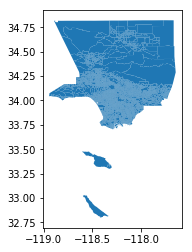

In [35]:
community_stat_area.plot()

In [36]:
#LA County TOWN_COUNCILS
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/2014/12/" \
      "DRP_TOWN_COUNCIL_AREAS.zip"
town_councils = download_egis3(url, 'DRP_TOWN_COUNCIL_AREAS.zip', 'town_councils', 'DRP_TOWN_COUNCIL_AREAS.shp')
dfname_list.append('town_councils')
checkdf(town_councils)

Total polygon number: 25
number of null and unique values in each column:
OBJECTID: null 0, unique 25
Id: null 0, unique 1
SupDist: null 0, unique 5
CertDate: null 25, unique 1
NAME: null 0, unique 21
SUB_REGION: null 0, unique 6
TYPE: null 0, unique 1
DRP_NOTES: null 0, unique 16
Shape_STAr: null 0, unique 25
Shape_STLe: null 0, unique 25


,OBJECTID,Id,SupDist,CertDate,NAME,SUB_REGION,TYPE,DRP_NOTES,Shape_STAr,Shape_STLe,geometry
0,1,0,5,None,Juniper Hills Town Council,,,done,1.412556e+09,162222.345363,POLYGON ((-117.9228713428042 34.48373342444793...
1,2,0,5,None,Leona Valley Town Council,,,CSD referenced in bylaws,4.161558e+08,159039.502427,POLYGON ((-118.3237207085177 34.63380740048827...
2,3,0,5,None,Acton Town Council,,,CSD,3.104176e+09,302459.764141,POLYGON ((-118.2066130257172 34.53937158856911...


In [37]:
droplist = ['Id', 'SupDist', 'CertDate', 'SUB_REGION', 'TYPE',
       'DRP_NOTES', 'Shape_STAr', 'Shape_STLe']
cleandf(town_councils, droplist)

,NAME,geometry
0,Juniper Hills Town Council,POLYGON ((-117.9228713428042 34.48373342444793...
1,Leona Valley Town Council,POLYGON ((-118.3237207085177 34.63380740048827...
2,Acton Town Council,POLYGON ((-118.2066130257172 34.53937158856911...


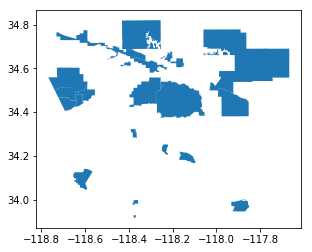

In [38]:
town_councils.plot()

In [39]:
#FIRE_DIVISION_BOUNDARIES
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/" \
      "ShapefilePackages/FIRE_DIVISION_BOUNDARIES.zip"
fire_division = download_egis3(url, 'FIRE_DIVISION_BOUNDARIES.zip', 'fire_division', 'FIRE_DIVISION_BOUNDARIES.shp')
dfname_list.append('fire_division')
checkdf(fire_division)

Total polygon number: 9
number of null and unique values in each column:
OBJECTID: null 0, unique 9
DIV: null 0, unique 9
Shape_Leng: null 0, unique 9
Shape_STAr: null 0, unique 9
Shape_STLe: null 0, unique 9


,OBJECTID,DIV,Shape_Leng,Shape_STAr,Shape_STLe,geometry
0,1,I,8.334326e+05,4.066853e+09,8.334326e+05,(POLYGON ((-118.6060576865897 33.4791081369531...
1,2,II,6.055937e+05,8.351965e+09,6.055937e+05,POLYGON ((-117.7457043664994 34.33837148403114...
2,3,III,1.470782e+06,2.491402e+10,1.470782e+06,(POLYGON ((-118.8804273943463 34.8178403050801...


In [40]:
droplist = ['Shape_Leng', 'Shape_STAr', 'Shape_STLe']
cleandf(fire_division, droplist)

,DIV,geometry
0,I,(POLYGON ((-118.6060576865897 33.4791081369531...
1,II,POLYGON ((-117.7457043664994 34.33837148403114...
2,III,(POLYGON ((-118.8804273943463 34.8178403050801...


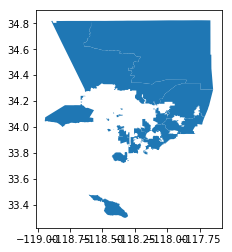

In [41]:
fire_division.plot()

In [42]:
#Los Angeles County Fire Department Battalion Boundaries
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/" \
      "ShapefilePackages/FIRE_BATTALION_BOUNDARIES.zip"
fire_battalion = download_egis3(url, 'FIRE_BATTALION_BOUNDARIES.zip', 'fire_battalion', 'FIRE_BATTALION_BOUNDARIES.shp')
dfname_list.append('fire_battalion')
checkdf(fire_battalion)

Total polygon number: 22
number of null and unique values in each column:
OBJECTID: null 0, unique 22
BATTID: null 0, unique 22
Shape_Leng: null 0, unique 22
Shape_STAr: null 0, unique 22
Shape_STLe: null 0, unique 22


,OBJECTID,BATTID,Shape_Leng,Shape_STAr,Shape_STLe,geometry
0,1,1,225880.985263,2.742210e+08,225880.985263,(POLYGON ((-118.3626353408748 34.0063866246520...
1,2,2,453772.402871,3.146341e+09,453772.402871,POLYGON ((-117.6587123201178 34.24037857785586...
2,3,3,158516.064622,5.869450e+08,158516.064622,(POLYGON ((-118.1777734260421 34.0622946700525...


In [43]:
droplist = ['Shape_Leng', 'Shape_STAr', 'Shape_STLe']
cleandf(fire_battalion, droplist)

,BATTID,geometry
0,1,(POLYGON ((-118.3626353408748 34.0063866246520...
1,2,POLYGON ((-117.6587123201178 34.24037857785586...
2,3,(POLYGON ((-118.1777734260421 34.0622946700525...


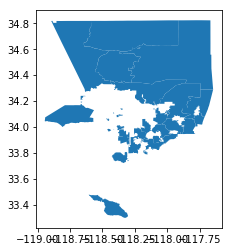

In [44]:
fire_battalion.plot()

In [45]:
#2011 Supervisorial District Boundaries (Official)
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/2011/12/" \
      "DPW-Supervisorial-District.zip"
supervisorial_district = download_egis3(url, 'DPW-Supervisorial-District.zip', 'supervisorial_district', 'sup_dist_2011.shp')
dfname_list.append('supervisorial_district')
checkdf(supervisorial_district)

Total polygon number: 5
number of null and unique values in each column:
OBJECTID: null 0, unique 5
SUP_DIST_N: null 0, unique 5
SYMBOL: null 0, unique 1
PERIMETER: null 0, unique 1
AREA_SQ_MI: null 0, unique 5
SHAPE_AREA: null 0, unique 5
SHAPE_LEN: null 0, unique 5


,OBJECTID,SUP_DIST_N,SYMBOL,PERIMETER,AREA_SQ_MI,SHAPE_AREA,SHAPE_LEN,geometry
0,1601,1,0,0.0,246.202,6.863264e+09,946818.102008,POLYGON ((-118.2845039326605 34.08665464600393...
1,1602,2,0,0.0,161.825,4.511450e+09,477092.243642,POLYGON ((-118.3063679014772 34.09079201094933...
2,1603,3,0,0.0,431.197,1.202126e+10,759927.656095,"POLYGON ((-118.506688035281 34.33409190867378,..."


In [46]:
droplist = ['SYMBOL', 'PERIMETER', 'AREA_SQ_MI', 'SHAPE_AREA', 'SHAPE_LEN']
cleandf(supervisorial_district, droplist)

,SUP_DIST_N,geometry
0,1,POLYGON ((-118.2845039326605 34.08665464600393...
1,2,POLYGON ((-118.3063679014772 34.09079201094933...
2,3,"POLYGON ((-118.506688035281 34.33409190867378,..."


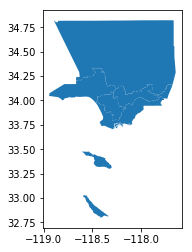

In [47]:
supervisorial_district.plot()

In [48]:
#LA City Council Districts (2012)
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/2012/08/" \
      "CnclDist_July2012.zip"
LAcity_council_dist = download_egis3(url, 'CnclDist_July2012.zip', 'LAcity_council_dist', 'CnclDist_July2012.shp')
dfname_list.append('LAcity_council_dist')
checkdf(LAcity_council_dist)

Total polygon number: 15
number of null and unique values in each column:
AREA: null 0, unique 15
PERIMETER: null 0, unique 15
CDMEMBER: null 0, unique 15
DISTRICT: null 0, unique 15
SQ_MI: null 0, unique 15
SHADESYM: null 0, unique 1
Revised: null 0, unique 1
Comments: null 0, unique 1
SHAPE_Leng: null 0, unique 15
SHAPE_Area: null 0, unique 15


,AREA,PERIMETER,CDMEMBER,DISTRICT,SQ_MI,SHADESYM,Revised,Comments,SHAPE_Leng,SHAPE_Area,geometry
0,1.508806e+09,345479.674422,Felipe Fuentes,7,54.12,10,07/02/2012,ORD 182168,345539.115290,1.508899e+09,POLYGON ((-118.5084667256651 34.33379445567272...
1,1.637593e+09,254031.923325,Mitchell Englander,12,58.74,10,07/02/2012,ORD 182168,253975.218622,1.637537e+09,POLYGON ((-118.5084667256651 34.33379445567272...
2,7.579624e+08,191215.747144,Nury Martinez,6,27.19,10,07/02/2012,ORD 182168,191215.747039,7.579624e+08,POLYGON ((-118.4729681280253 34.23192967092903...


In [49]:
droplist = ['AREA', 'PERIMETER', 'CDMEMBER', 'SQ_MI', 'SHADESYM',
       'Revised', 'Comments', 'SHAPE_Leng', 'SHAPE_Area']
cleandf(LAcity_council_dist, droplist)

,DISTRICT,geometry
0,7,POLYGON ((-118.5084667256651 34.33379445567272...
1,12,POLYGON ((-118.5084667256651 34.33379445567272...
2,6,POLYGON ((-118.4729681280253 34.23192967092903...


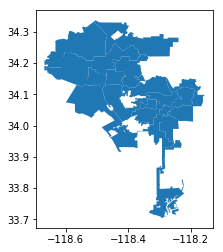

In [50]:
LAcity_council_dist.plot()

In [51]:
#State Assembly Districts (State Legislative District – Lower Chamber)
!wget https://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_06_sldl_500k.zip
legislative_lower = read_census('cb_2016_06_sldl_500k.zip', 'legislative_lower', 'cb_2016_06_sldl_500k.shp')
dfname_list.append('legislative_lower')
checkdf(legislative_lower)

--2018-01-05 23:43:20--  https://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_06_sldl_500k.zip
Resolving www2.census.gov... 2600:1408:24:5aa::208c, 2600:1408:24:599::208c, 104.121.83.95
Connecting to www2.census.gov|2600:1408:24:5aa::208c|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 612466 (598K) [application/zip]
Saving to: 'cb_2016_06_sldl_500k.zip.3'

cb_2016_06_sldl_500 100%[===================>] 598.11K  1.60MB/s    in 0.4s    

2018-01-05 23:43:21 (1.60 MB/s) - 'cb_2016_06_sldl_500k.zip.3' saved [612466/612466]

Total polygon number: 80
number of null and unique values in each column:
STATEFP: null 0, unique 1
SLDLST: null 0, unique 80
AFFGEOID: null 0, unique 80
GEOID: null 0, unique 80
NAME: null 0, unique 80
LSAD: null 0, unique 1
LSY: null 0, unique 1
ALAND: null 0, unique 80
AWATER: null 0, unique 80


,STATEFP,SLDLST,AFFGEOID,GEOID,NAME,LSAD,LSY,ALAND,AWATER,geometry
0,06,036,620L500US06036,06036,36,L3,2016,7179257039,28222885,"POLYGON ((-118.894474 34.817972, -118.884388 3..."
1,06,057,620L500US06057,06057,57,L3,2016,237746318,2222703,"POLYGON ((-118.099942 33.904934, -118.099517 3..."
2,06,055,620L500US06055,06055,55,L3,2016,410765132,1985765,"POLYGON ((-117.976692 33.910614, -117.976571 3..."


In [52]:
droplist = ['STATEFP', 'SLDLST', 'AFFGEOID', 'GEOID', 'LSAD', 'LSY',
       'ALAND', 'AWATER']
cleandf(legislative_lower, droplist)

,NAME,geometry
0,36,"POLYGON ((-118.894474 34.817972, -118.884388 3..."
1,57,"POLYGON ((-118.099942 33.904934, -118.099517 3..."
2,55,"POLYGON ((-117.976692 33.910614, -117.976571 3..."


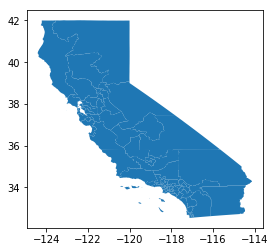

In [53]:
legislative_lower.plot()

In [54]:
#Registrar Recorder Precincts
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/" \
      "ShapefilePackages/RRCC_PRECINCTS.zip"
election_precinct = download_egis3(url, 'RRCC_PRECINCTS.zip', 'election_precinct', 'RRCC_PRECINCTS.shp')
dfname_list.append('election_precinct')
checkdf(election_precinct)

Total polygon number: 33601
number of null and unique values in each column:
PRECINCT: null 0, unique 33601
CITY_EST: null 0, unique 7992
SUBCODE: null 0, unique 26
MAP1: null 0, unique 1
DIST_RES: null 0, unique 1
DIST_CONG: null 0, unique 18
DIST_STSEN: null 0, unique 15
DIST_STASS: null 0, unique 24
DIST_SUP: null 0, unique 5
DIST_MCRT: null 0, unique 1
DIST_BEQ: null 0, unique 2
DST_CITY: null 0, unique 89
DIV_CITY: null 0, unique 95
DST_RES2: null 0, unique 1
DIV_RES2: null 0, unique 1
DST_JRC: null 0, unique 15
DIV_JRC: null 0, unique 8
DST_USD: null 0, unique 50
DIV_USD: null 0, unique 8
DST_HSD: null 0, unique 8
DIV_HSD: null 0, unique 6
DST_ESD: null 0, unique 30
DIV_ESD: null 0, unique 6
DST_HOSP: null 0, unique 3
DIV_HOSP: null 0, unique 1
DST_PARK: null 0, unique 5
DIV_PARK: null 0, unique 3
DST_WA: null 0, unique 2
DIV_WA: null 0, unique 1
DST_MWD: null 0, unique 9
DIV_MWD: null 0, unique 8
DST_WR: null 0, unique 2
DIV_WR: null 0, unique 6
DST_WAG: null 0, unique 3
DIV_WAG

,PRECINCT,CITY_EST,SUBCODE,MAP1,DIST_RES,DIST_CONG,DIST_STSEN,DIST_STASS,DIST_SUP,DIST_MCRT,...,COMM_CODE,COMM_NAME,AREA_CODE,AREA_NAME,PRC_NAME,CITY,ESTAB,Shape_STAr,Shape_STLe,geometry
0,9001742B,9001742,B,0.0,,34.0,24.0,53.0,1.0,,...,900.0,LOS ANGELES,809.0,CENTRAL AREA,LOS ANGELES,900,1742,453984.737305,2713.125981,POLYGON ((-118.2776159595675 34.05073225085379...
1,9001742C,9001742,C,0.0,,34.0,24.0,53.0,1.0,,...,900.0,LOS ANGELES,809.0,CENTRAL AREA,LOS ANGELES,900,1742,766784.173828,3820.588904,POLYGON ((-118.2828304354189 34.04931735342003...
2,9001742E,9001742,E,0.0,,34.0,24.0,53.0,1.0,,...,900.0,LOS ANGELES,809.0,CENTRAL AREA,LOS ANGELES,900,1742,566946.030273,3362.362112,POLYGON ((-118.2835241269783 34.05237068362484...


This shapefile itself is a geocrosswalk! But the metadata is not in perfect quality, so some columns' meaning are unknown.

In [55]:
droplist = [ 'CITY_EST', 'SUBCODE', 'MAP1',
 'DIST_RES', 'DIST_MCRT', 'DIST_BEQ',
 'DST_CITY', 'DIV_CITY', 'DST_RES2', 'DIV_RES2',
 'DST_JRC', 'DIV_JRC', 'DST_USD', 'DIV_USD',
 'DST_HSD', 'DIV_HSD', 'DST_ESD', 'DIV_ESD',
 'DST_HOSP', 'DIV_HOSP', 'DST_PARK', 'DIV_PARK',
 'DST_WA', 'DIV_WA', 'DST_MWD', 'DIV_MWD',
 'DST_WR', 'DIV_WR', 'DST_WAG', 'DIV_WAG',
 'DST_CW', 'DIV_CW', 'DST_IRR', 'DIV_IRR',
 'DST_CS', 'DIV_CS', 'DST_LIB', 'DIV_LIB',
 'DST_RC', 'DIV_RC', 'DST_CAW', 'DIV_CAW',
 'DST_CEM', 'DIV_CEM', 'DST_MOS', 'DIV_MOS',
 'DST_SAN', 'DIV_SAN', 'DST_TRN', 'DIV_TRN',
 'DST_RES3', 'DIV_RES3', 'DST_FIR', 'DIV_FIR',
 'DST_FLD', 'DIV_FLD', 'DST_GARB', 'DIV_GARB',
 'DIST_OLDC', 'DIST_OLDS', 'DIST_OLDA', 'DST_CL', 'DIV_CL',
 'DST_SM', 'DIV_SM', 'DST_RD', 'DIV_RD',
 'DST_MISC1', 'DIV_MISC1', 'DST_MISC2', 'DIV_MISC2',
 'DST_MISC3', 'DIV_MISC3', 'DST_MISC4', 'DIV_MISC4',
 'DST_MISC5', 'DIV_MISC5', 'DST_MISC6', 'DIV_MISC6',
 'DST_ANX1', 'DIV_ANX1', 'DST_ANX2', 'DIV_ANX2',
 'DST_ANX3', 'DIV_ANX3', 'DST_ANX4', 'DIV_ANX4',
 'DST_ANX5', 'DIV_ANX5', 'CT_YEAR1', 'CT_YEAR2', 'CTRACT1',
 'CTRACT2', 'ESTAB', 'Shape_STAr', 'Shape_STLe']
cleandf(election_precinct, droplist)

,PRECINCT,DIST_CONG,DIST_STSEN,DIST_STASS,DIST_SUP,COMM_CODE,COMM_NAME,AREA_CODE,AREA_NAME,PRC_NAME,CITY,geometry
0,9001742B,34.0,24.0,53.0,1.0,900.0,LOS ANGELES,809.0,CENTRAL AREA,LOS ANGELES,900,POLYGON ((-118.2776159595675 34.05073225085379...
1,9001742C,34.0,24.0,53.0,1.0,900.0,LOS ANGELES,809.0,CENTRAL AREA,LOS ANGELES,900,POLYGON ((-118.2828304354189 34.04931735342003...
2,9001742E,34.0,24.0,53.0,1.0,900.0,LOS ANGELES,809.0,CENTRAL AREA,LOS ANGELES,900,POLYGON ((-118.2835241269783 34.05237068362484...


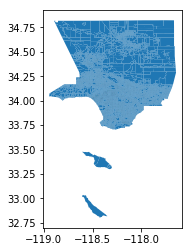

In [56]:
election_precinct.plot()

In [57]:
#Comunity Plan Areas
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/2015/09/" \
      "LACITY_COMMUNITY_PLAN_AREAS.zip"
comunity_plan_area = download_egis3(url, 'LACITY_COMMUNITY_PLAN_AREAS.zip', 'comunity_plan_area', 'LACITY_COMMUNITY_PLAN_AREAS.shp')
dfname_list.append('comunity_plan_area')
checkdf(comunity_plan_area)

Total polygon number: 39
number of null and unique values in each column:
OBJECTID: null 0, unique 39
CPA_NUM: null 0, unique 37
NAME_ALF: null 0, unique 37
CPA: null 0, unique 37
Shape_STAr: null 0, unique 39
Shape_STLe: null 0, unique 39


,OBJECTID,CPA_NUM,NAME_ALF,CPA,Shape_STAr,Shape_STLe,geometry
0,7,2120,Sherman Oaks - Studio City - Toluca Lake - Cah...,SHR,3.826169e+08,142873.185393,POLYGON ((-118.4429925272998 34.15515304395149...
1,8,3310,Brentwood - Pacific Palisades,BTW,1.060862e+09,167625.600787,POLYGON ((-118.5992042036877 34.07433663548211...
2,13,1010,Northeast Los Angeles,NLA,6.829526e+08,167982.025214,POLYGON ((-118.2261196221428 34.06217740937344...


In [58]:
droplist = ['CPA', 'Shape_STAr', 'Shape_STLe']
cleandf(comunity_plan_area, droplist)

,CPA_NUM,NAME_ALF,geometry
0,2120,Sherman Oaks - Studio City - Toluca Lake - Cah...,POLYGON ((-118.4429925272998 34.15515304395149...
1,3310,Brentwood - Pacific Palisades,POLYGON ((-118.5992042036877 34.07433663548211...
2,1010,Northeast Los Angeles,POLYGON ((-118.2261196221428 34.06217740937344...


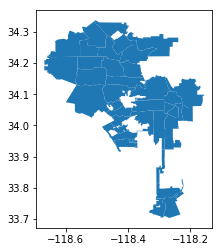

In [59]:
comunity_plan_area.plot()

In [60]:
#CDC Project Areas
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/" \
      "ShapefilePackages/CDC_PROJECT_AREAS.zip"
cdc_project = download_egis3(url, 'CDC_PROJECT_AREAS.zip', 'cdc_project', 'CDC_PROJECT_AREAS.shp')
dfname_list.append('cdc_project')
checkdf(cdc_project)

Total polygon number: 15
number of null and unique values in each column:
Program: null 0, unique 14
Division: null 0, unique 1
Type: null 0, unique 4
Active: null 0, unique 1
Label: null 0, unique 15
Shape_STAr: null 0, unique 15
Shape_STLe: null 0, unique 15


,Program,Division,Type,Active,Label,Shape_STAr,Shape_STLe,geometry
0,Willowbrook Community Community Business Revit...,EHD,community business revitalization program,1,Willowbrook CRPA,1.578942e+07,17490.190856,POLYGON ((-118.2379532338418 33.92932791407109...
1,Maravilla Community Business Revitalization Area,EHD,community business revitalization program,1,Maravilla CBRA,9.146995e+06,13347.617242,POLYGON ((-118.1695150200878 34.04420325573447...
2,East Rancho Dominguez Community Business Revit...,EHD,community business revitalization program,1,East Rancho Dominguez CBRA,2.375246e+06,12758.329334,POLYGON ((-118.1983083929402 33.89555436587284...


In [61]:
droplist = ['Division', 'Type', 'Active', 'Label', 'Shape_STAr', 'Shape_STLe']
cleandf(cdc_project, droplist)

,Program,geometry
0,Willowbrook Community Community Business Revit...,POLYGON ((-118.2379532338418 33.92932791407109...
1,Maravilla Community Business Revitalization Area,POLYGON ((-118.1695150200878 34.04420325573447...
2,East Rancho Dominguez Community Business Revit...,POLYGON ((-118.1983083929402 33.89555436587284...


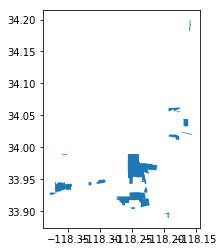

In [62]:
cdc_project.plot()

In [63]:
#Census Tract
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/" \
      "ShapefilePackages/CENSUS_TRACTS_2010.zip"
census_tract = download_egis3(url, 'CENSUS_TRACTS_2010.zip', 'census_tract', 'CENSUS_TRACTS_2010.shp')
dfname_list.append('census_tract')
checkdf(census_tract)

Total polygon number: 2344
number of null and unique values in each column:
GEOID10: null 0, unique 2344
CT10: null 0, unique 2344
LABEL: null 0, unique 2344
X_Center: null 0, unique 2330
Y_Center: null 0, unique 2327
Shape_STAr: null 0, unique 2344
Shape_STLe: null 0, unique 2344


,GEOID10,CT10,LABEL,X_Center,Y_Center,Shape_STAr,Shape_STLe,geometry
0,06037911001,911001,9110.01,6620403.0,1998891.0,4.025736e+09,353933.808192,POLYGON ((-117.6671211145405 34.55800813746517...
1,06037980003,980003,9800.03,6575300.0,2112006.0,2.078690e+09,273188.863210,POLYGON ((-117.8806120015536 34.76361599875383...
2,06037930301,930301,9303.01,6603027.0,1932124.0,1.111802e+10,628603.531323,"POLYGON ((-117.655235839948 34.39722196554438,..."


In [64]:
droplist = ['LABEL', 'X_Center', 'Y_Center', 'Shape_STAr', 'Shape_STLe']
cleandf(census_tract, droplist)

,GEOID10,CT10,geometry
0,06037911001,911001,POLYGON ((-117.6671211145405 34.55800813746517...
1,06037980003,980003,POLYGON ((-117.8806120015536 34.76361599875383...
2,06037930301,930301,"POLYGON ((-117.655235839948 34.39722196554438,..."


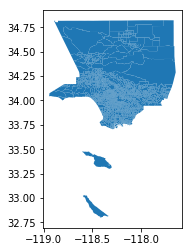

In [65]:
census_tract.plot()

In [66]:
#Census Blocks
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/" \
      "ShapefilePackages/CENSUS_BLOCKS_2010.zip"
census_blocks = download_egis3(url, 'CENSUS_BLOCKS_2010.zip', 'census_blocks', 'CENSUS_BLOCKS_2010.shp')
dfname_list.append('census_blocks')
checkdf(census_blocks)

Total polygon number: 109279
number of null and unique values in each column:
CT10: null 0, unique 2344
BG10: null 0, unique 6422
CB10: null 0, unique 1975
CTCB10: null 0, unique 109279
BG10FIP10: null 0, unique 6972
CEN_FIP13: null 0, unique 142
LA_FIP10: null 0, unique 89
CITY: null 0, unique 89
COMM: null 0, unique 232
CITYCOM: null 0, unique 257
ZCTA10: null 0, unique 301
PUMA10: null 0, unique 70
HD_2012: null 0, unique 26
HD_NAME: null 0, unique 26
SPA_2012: null 0, unique 8
SPA_NAME: null 0, unique 8
SUP_DIST: null 0, unique 5
SUP_LABEL: null 0, unique 5
HOUSING10: null 0, unique 639
POP_2010: null 0, unique 1270
CT12: null 0, unique 2345
BG12: null 0, unique 6423
Shape_STAr: null 0, unique 109259
Shape_STLe: null 0, unique 109279


,CT10,BG10,CB10,CTCB10,BG10FIP10,CEN_FIP13,LA_FIP10,CITY,COMM,CITYCOM,...,SPA_NAME,SUP_DIST,SUP_LABEL,HOUSING10,POP_2010,CT12,BG12,Shape_STAr,Shape_STLe,geometry
0,650001,6500012,2004,6500012004,650001280000,80000,80000,Torrance,Torrance,City of Torrance,...,South Bay,4,District 4,13,39,650001,6500012,122799.112305,1811.062718,POLYGON ((-118.3196050007964 33.88240599913712...
1,650902,6509021,1045,6509021045,650902180000,80000,80000,Torrance,Torrance,City of Torrance,...,South Bay,4,District 4,0,0,650902,6509021,19197.034180,845.026552,POLYGON ((-118.3154650016074 33.82442799911141...
2,670407,6704071,1015,6704071015,670407159514,59514,59514,Rancho Palos Verdes,Rancho Palos Verdes,City of Rancho Palos Verdes,...,South Bay,4,District 4,1,5,670407,6704071,4159.323242,317.758051,POLYGON ((-118.3899240008091 33.77733799949572...


In [67]:
droplist = ['POP_2010', 'CT12', 'BG12', 'Shape_STAr', 'Shape_STLe',
           'HOUSING10', 'SUP_LABEL', 'SPA_NAME', 'CEN_FIP13', 'SPA_2012']
cleandf(census_blocks, droplist)

,CT10,BG10,CB10,CTCB10,BG10FIP10,LA_FIP10,CITY,COMM,CITYCOM,ZCTA10,PUMA10,HD_2012,HD_NAME,SUP_DIST,geometry
0,650001,6500012,2004,6500012004,650001280000,80000,Torrance,Torrance,City of Torrance,90504,03761,79,Torrance,4,POLYGON ((-118.3196050007964 33.88240599913712...
1,650902,6509021,1045,6509021045,650902180000,80000,Torrance,Torrance,City of Torrance,90501,03761,79,Torrance,4,POLYGON ((-118.3154650016074 33.82442799911141...
2,670407,6704071,1015,6704071015,670407159514,59514,Rancho Palos Verdes,Rancho Palos Verdes,City of Rancho Palos Verdes,90275,03768,31,Harbor,4,POLYGON ((-118.3899240008091 33.77733799949572...


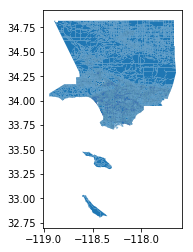

In [68]:
census_blocks.plot()

In [69]:
dfname_list

['health_districts',
 'law_enforcement',
 'school_districts',
 'state_senate',
 'congressional_districts',
 'zip_code',
 'puma',
 'county_communities',
 'community_stat_area',
 'town_councils',
 'fire_division',
 'fire_battalion',
 'supervisorial_district',
 'LAcity_council_dist',
 'legislative_lower',
 'election_precinct',
 'comunity_plan_area',
 'cdc_project',
 'census_tract',
 'census_blocks']

## Datasets used this week:

- [Law Enforcement Reporting Districts](https://egis3.lacounty.gov/dataportal/2010/10/05/law-enforcement-reporting-districts/)
- [LAcounty_COMMUNITIES](https://egis3.lacounty.gov/dataportal/2010/10/21/citycommunity-boundaries/)
- [Registrar Recorder Precincts](https://egis3.lacounty.gov/dataportal/2012/12/20/2012-precincts-as-of-march-9th/)
- [Census Block (2010)](http://egis3.lacounty.gov/dataportal/2016/01/26/census_blocks/)
- [School District Boundaries (2011)](http://egis3.lacounty.gov/dataportal/2012/01/20/school-district-boundaries-2011/)

In [7]:
dfname_list = []

#### 1. Law Enforcement Reporting Districts

In [8]:
#Law Enforcement Reporting Districts
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/" \
      "ShapefilePackages/LACOUNTY_LAW_ENFORCEMENT_RDs.zip"
law_enforcement = download_egis3(url, 'LACOUNTY_LAW_ENFORCEMENT_RDs.zip', 'law_enforcement', 'LACOUNTY_LAW_ENFORCEMENT_RDs.shp')
dfname_list.append('law_enforcement')
checkdf(law_enforcement)

Total polygon number: 5745
number of null and unique values in each column:
RD: null 0, unique 3667
Name: null 0, unique 519
Layer: null 0, unique 3


,RD,Name,Layer,geometry
0,0230,Belvedere,Parks Bureau,POLYGON ((-118.1604325432619 34.03712079823092...
1,0231,Atlantic Avenue,Parks Bureau,"POLYGON ((-118.1550797745909 34.0257529106941,..."
2,0232,City Terrace,Parks Bureau,POLYGON ((-118.1784888821586 34.04781649689102...


In [9]:
droplist = ['Layer']
cleandf(law_enforcement, droplist)

,RD,Name,geometry
0,0230,Belvedere,POLYGON ((-118.1604325432619 34.03712079823092...
1,0231,Atlantic Avenue,"POLYGON ((-118.1550797745909 34.0257529106941,..."
2,0232,City Terrace,POLYGON ((-118.1784888821586 34.04781649689102...


In [10]:
law_enforcement.columns = ['repo_dist_num', 'repo_dist_name',
                           'geometry']

#### 2. LAcounty_COMMUNITIES

In [11]:
#LAcounty_COMMUNITIES
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/2010/10/" \
      "Communities1.zip"
county_communities = download_egis3(url, 'Communities1.zip', 'county_communities', 'Communities.shp')
dfname_list.append('county_communities')
checkdf(county_communities)

Total polygon number: 353
number of null and unique values in each column:
COMMTYPE: null 0, unique 3
NAME: null 0, unique 206
COLOR: null 0, unique 7
PO_NAME: null 0, unique 177
STATNAME: null 0, unique 193
X_CENTER: null 0, unique 353
Y_CENTER: null 0, unique 353
ST_NAME: null 0, unique 88
LABEL_CITY: null 0, unique 89
LABEL_COMM: null 0, unique 143
AREA_SQMI: null 0, unique 322
Shape_area: null 0, unique 353
Shape_len: null 0, unique 353


,COMMTYPE,NAME,COLOR,PO_NAME,STATNAME,X_CENTER,Y_CENTER,ST_NAME,LABEL_CITY,LABEL_COMM,AREA_SQMI,Shape_area,Shape_len,geometry
0,Unincorporated,Edwards,Yellow,Edwards,East Antelope Valley,6590507,2111007,Lancaster,Unincorporated,Edwards,93.961,2.619470e+09,337914.985138,POLYGON ((-118.1407088589749 34.81827748625132...
1,Unincorporated,Gorman,Yellow,West Antelope Valley,West Antelope Valley,6357449,2089258,Santa Clarita Valley,Unincorporated,Gorman,173.752,4.843936e+09,442757.717076,POLYGON ((-118.4662754936974 34.81837563424517...
2,Unincorporated,Del Sur,Yellow,Lancaster,Quartz Hill,6469031,2091460,Lancaster,Unincorporated,Del Sur,135.398,3.774671e+09,423904.059503,POLYGON ((-118.4662754936974 34.81837563424517...


In [12]:
droplist = ['COMMTYPE', 'COLOR', 'PO_NAME', 'STATNAME', 'X_CENTER',
       'Y_CENTER', 'ST_NAME', 'LABEL_CITY', 'LABEL_COMM', 'AREA_SQMI']
cleandf(county_communities, droplist)

,NAME,geometry
0,Edwards,POLYGON ((-118.1407088589749 34.81827748625132...
1,Gorman,POLYGON ((-118.4662754936974 34.81837563424517...
2,Del Sur,POLYGON ((-118.4662754936974 34.81837563424517...


In [13]:
county_communities.columns = ['coun_comm_name', 'geometry']

In [ ]:
print ('overlay_shp {}'.format(law_enforcement.shape))
print ('county_communities {}'.format(county_communities.shape))

In [14]:
overlay_shp = spatial_overlays(law_enforcement, county_communities)

In [15]:
print ('After overlay: {}'.format(overlay_shp.shape))
#overlay_shp.plot()

After overlay: (9599, 4)


####  3. Registrar Recorder Precincts

In [16]:
#Registrar Recorder Precincts
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/" \
      "ShapefilePackages/RRCC_PRECINCTS.zip"
election_precinct = download_egis3(url, 'RRCC_PRECINCTS.zip', 'election_precinct', 'RRCC_PRECINCTS.shp')
dfname_list.append('election_precinct')
checkdf(election_precinct)

Total polygon number: 33601
number of null and unique values in each column:
PRECINCT: null 0, unique 33601
CITY_EST: null 0, unique 7992
SUBCODE: null 0, unique 26
MAP1: null 0, unique 1
DIST_RES: null 0, unique 1
DIST_CONG: null 0, unique 18
DIST_STSEN: null 0, unique 15
DIST_STASS: null 0, unique 24
DIST_SUP: null 0, unique 5
DIST_MCRT: null 0, unique 1
DIST_BEQ: null 0, unique 2
DST_CITY: null 0, unique 89
DIV_CITY: null 0, unique 95
DST_RES2: null 0, unique 1
DIV_RES2: null 0, unique 1
DST_JRC: null 0, unique 15
DIV_JRC: null 0, unique 8
DST_USD: null 0, unique 50
DIV_USD: null 0, unique 8
DST_HSD: null 0, unique 8
DIV_HSD: null 0, unique 6
DST_ESD: null 0, unique 30
DIV_ESD: null 0, unique 6
DST_HOSP: null 0, unique 3
DIV_HOSP: null 0, unique 1
DST_PARK: null 0, unique 5
DIV_PARK: null 0, unique 3
DST_WA: null 0, unique 2
DIV_WA: null 0, unique 1
DST_MWD: null 0, unique 9
DIV_MWD: null 0, unique 8
DST_WR: null 0, unique 2
DIV_WR: null 0, unique 6
DST_WAG: null 0, unique 3
DIV_WAG

,PRECINCT,CITY_EST,SUBCODE,MAP1,DIST_RES,DIST_CONG,DIST_STSEN,DIST_STASS,DIST_SUP,DIST_MCRT,...,COMM_CODE,COMM_NAME,AREA_CODE,AREA_NAME,PRC_NAME,CITY,ESTAB,Shape_STAr,Shape_STLe,geometry
0,9001742B,9001742,B,0.0,,34.0,24.0,53.0,1.0,,...,900.0,LOS ANGELES,809.0,CENTRAL AREA,LOS ANGELES,900,1742,453984.737305,2713.125981,POLYGON ((-118.2776159595675 34.05073225085379...
1,9001742C,9001742,C,0.0,,34.0,24.0,53.0,1.0,,...,900.0,LOS ANGELES,809.0,CENTRAL AREA,LOS ANGELES,900,1742,766784.173828,3820.588904,POLYGON ((-118.2828304354189 34.04931735342003...
2,9001742E,9001742,E,0.0,,34.0,24.0,53.0,1.0,,...,900.0,LOS ANGELES,809.0,CENTRAL AREA,LOS ANGELES,900,1742,566946.030273,3362.362112,POLYGON ((-118.2835241269783 34.05237068362484...


In [17]:
droplist = [ 'CITY_EST', 'SUBCODE', 'MAP1',
 'DIST_RES', 'DIST_MCRT', 'DIST_BEQ',
 'DST_CITY', 'DIV_CITY', 'DST_RES2', 'DIV_RES2',
 'DST_JRC', 'DIV_JRC', 'DST_USD', 'DIV_USD',
 'DST_HSD', 'DIV_HSD', 'DST_ESD', 'DIV_ESD',
 'DST_HOSP', 'DIV_HOSP', 'DST_PARK', 'DIV_PARK',
 'DST_WA', 'DIV_WA', 'DST_MWD', 'DIV_MWD',
 'DST_WR', 'DIV_WR', 'DST_WAG', 'DIV_WAG',
 'DST_CW', 'DIV_CW', 'DST_IRR', 'DIV_IRR',
 'DST_CS', 'DIV_CS', 'DST_LIB', 'DIV_LIB',
 'DST_RC', 'DIV_RC', 'DST_CAW', 'DIV_CAW',
 'DST_CEM', 'DIV_CEM', 'DST_MOS', 'DIV_MOS',
 'DST_SAN', 'DIV_SAN', 'DST_TRN', 'DIV_TRN',
 'DST_RES3', 'DIV_RES3', 'DST_FIR', 'DIV_FIR',
 'DST_FLD', 'DIV_FLD', 'DST_GARB', 'DIV_GARB',
 'DIST_OLDC', 'DIST_OLDS', 'DIST_OLDA', 'DST_CL', 'DIV_CL',
 'DST_SM', 'DIV_SM', 'DST_RD', 'DIV_RD',
 'DST_MISC1', 'DIV_MISC1', 'DST_MISC2', 'DIV_MISC2',
 'DST_MISC3', 'DIV_MISC3', 'DST_MISC4', 'DIV_MISC4',
 'DST_MISC5', 'DIV_MISC5', 'DST_MISC6', 'DIV_MISC6',
 'DST_ANX1', 'DIV_ANX1', 'DST_ANX2', 'DIV_ANX2',
 'DST_ANX3', 'DIV_ANX3', 'DST_ANX4', 'DIV_ANX4',
 'DST_ANX5', 'DIV_ANX5', 'CT_YEAR1', 'CT_YEAR2', 'CTRACT1',
 'CTRACT2', 'ESTAB', 'Shape_STAr', 'Shape_STLe',
           'DIST_SUP', 'CITY']
cleandf(election_precinct, droplist)

,PRECINCT,DIST_CONG,DIST_STSEN,DIST_STASS,COMM_CODE,COMM_NAME,AREA_CODE,AREA_NAME,PRC_NAME,geometry
0,9001742B,34.0,24.0,53.0,900.0,LOS ANGELES,809.0,CENTRAL AREA,LOS ANGELES,POLYGON ((-118.2776159595675 34.05073225085379...
1,9001742C,34.0,24.0,53.0,900.0,LOS ANGELES,809.0,CENTRAL AREA,LOS ANGELES,POLYGON ((-118.2828304354189 34.04931735342003...
2,9001742E,34.0,24.0,53.0,900.0,LOS ANGELES,809.0,CENTRAL AREA,LOS ANGELES,POLYGON ((-118.2835241269783 34.05237068362484...


In [18]:
election_precinct.columns = ['precinct_num', 'congress_dist', 'senate_dist', 
                    'assembly_dist', 'community_num',
                    'community_name', 'area_num', 'area_name', 
                    'precinct_name', 'geometry']

In [19]:
print ('overlay_shp {}'.format(overlay_shp.shape))
print ('election_precinct {}'.format(election_precinct.shape))

overlay_shp (9599, 4)
election_precinct (33601, 10)


In [20]:
overlay_shp = spatial_overlays(overlay_shp, election_precinct)

In [21]:
print ('After overlay: {}'.format(overlay_shp.shape))
#overlay_shp.plot()

After overlay: (98406, 13)


#### 4. Census Blocks

In [22]:
#Census Blocks
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/" \
      "ShapefilePackages/CENSUS_BLOCKS_2010.zip"
census_blocks = download_egis3(url, 'CENSUS_BLOCKS_2010.zip', 'census_blocks', 'CENSUS_BLOCKS_2010.shp')
dfname_list.append('census_blocks')
checkdf(census_blocks)

Total polygon number: 109279
number of null and unique values in each column:
CT10: null 0, unique 2344
BG10: null 0, unique 6422
CB10: null 0, unique 1975
CTCB10: null 0, unique 109279
BG10FIP10: null 0, unique 6972
CEN_FIP13: null 0, unique 142
LA_FIP10: null 0, unique 89
CITY: null 0, unique 89
COMM: null 0, unique 232
CITYCOM: null 0, unique 257
ZCTA10: null 0, unique 301
PUMA10: null 0, unique 70
HD_2012: null 0, unique 26
HD_NAME: null 0, unique 26
SPA_2012: null 0, unique 8
SPA_NAME: null 0, unique 8
SUP_DIST: null 0, unique 5
SUP_LABEL: null 0, unique 5
HOUSING10: null 0, unique 639
POP_2010: null 0, unique 1270
CT12: null 0, unique 2345
BG12: null 0, unique 6423
Shape_STAr: null 0, unique 109259
Shape_STLe: null 0, unique 109279


,CT10,BG10,CB10,CTCB10,BG10FIP10,CEN_FIP13,LA_FIP10,CITY,COMM,CITYCOM,...,SPA_NAME,SUP_DIST,SUP_LABEL,HOUSING10,POP_2010,CT12,BG12,Shape_STAr,Shape_STLe,geometry
0,650001,6500012,2004,6500012004,650001280000,80000,80000,Torrance,Torrance,City of Torrance,...,South Bay,4,District 4,13,39,650001,6500012,122799.112305,1811.062718,POLYGON ((-118.3196050007964 33.88240599913712...
1,650902,6509021,1045,6509021045,650902180000,80000,80000,Torrance,Torrance,City of Torrance,...,South Bay,4,District 4,0,0,650902,6509021,19197.034180,845.026552,POLYGON ((-118.3154650016074 33.82442799911141...
2,670407,6704071,1015,6704071015,670407159514,59514,59514,Rancho Palos Verdes,Rancho Palos Verdes,City of Rancho Palos Verdes,...,South Bay,4,District 4,1,5,670407,6704071,4159.323242,317.758051,POLYGON ((-118.3899240008091 33.77733799949572...


In [23]:
droplist = ['POP_2010', 'CT12', 'BG12', 'Shape_STAr', 'Shape_STLe',
           'HOUSING10', 'SUP_LABEL', 'SPA_NAME', 'CEN_FIP13', 
            'SPA_2012', 'CTCB10', 'BG10FIP10', 'COMM', 'CITYCOM']
cleandf(census_blocks, droplist)

,CT10,BG10,CB10,LA_FIP10,CITY,ZCTA10,PUMA10,HD_2012,HD_NAME,SUP_DIST,geometry
0,650001,6500012,2004,80000,Torrance,90504,03761,79,Torrance,4,POLYGON ((-118.3196050007964 33.88240599913712...
1,650902,6509021,1045,80000,Torrance,90501,03761,79,Torrance,4,POLYGON ((-118.3154650016074 33.82442799911141...
2,670407,6704071,1015,59514,Rancho Palos Verdes,90275,03768,31,Harbor,4,POLYGON ((-118.3899240008091 33.77733799949572...


In [24]:
census_blocks.columns = ['census_tract', 'block_group', 
                         'census_block', 'FIP', 'city',
                         'zip_code', 'PUMA', 
                         'health_dist_num', 'health_districts_name',
                         'sup_dist', 'geometry']

In [25]:
print ('overlay_shp {}'.format(overlay_shp.shape))
print ('census_blocks {}'.format(census_blocks.shape))

overlay_shp (98406, 13)
census_blocks (109279, 11)


In [26]:
overlay_shp = spatial_overlays(overlay_shp, census_blocks)

In [27]:
print ('After overlay: {}'.format(overlay_shp.shape))
#overlay_shp.plot()

After overlay: (462901, 23)


In [28]:
overlay_shp.to_file("result.shp")

#### 5. School District Boundaries (2011) (gives error)

In [29]:
#School District Boundaries (2011)
url = "http://egis3.lacounty.gov/dataportal/wp-content/uploads/2012/01/" \
      "rrcc_school_districts1.zip"
school_districts = download_egis3(url, 'rrcc_school_districts1.zip', 'school_districts', 'rrcc_school_districts.shp')
dfname_list.append('school_districts')
checkdf(school_districts)

Total polygon number: 79
number of null and unique values in each column:
DISTRICT: null 0, unique 78
UNIFIED: null 0, unique 49
HIGH: null 0, unique 9
ELEMENTARY: null 0, unique 31
PH: null 0, unique 78
ADDR: null 0, unique 78
PH2: null 0, unique 20
PH3: null 0, unique 6
STU: null 0, unique 78
HI_ADDR: null 0, unique 9
HI_PH: null 0, unique 9
HI_STU: null 0, unique 9
LABEL: null 0, unique 78


,DISTRICT,UNIFIED,HIGH,ELEMENTARY,PH,ADDR,PH2,PH3,STU,HI_ADDR,HI_PH,HI_STU,LABEL,geometry
0,HERMOSA BEACH CITY ELEMENTARY,,,HERMOSA BEACH CITY ELEMENTARY,310 937 5877,1645 VALLEY DR HERMOSA BCH 90254,,,950,,,,HERMOSA BEACH CITY ELEM,POLYGON ((-118.4048577253546 33.87782346394338...
1,CENTINELA VALLEY UNION HIGH/HAWTHORNE ELEMENTARY,,CENTINELA VALLEY UNION HIGH,HAWTHORNE ELEMENTARY,310 676 2276,14120 S HAWTHORNE BL HAWTHORNE 90250,,,8145,14901 S INGLEWOOD AV LAWNDALE 90260,310 263 3200,6220,CENTINELA VALLEY UNION HIGH\nHAWTHORNE ELEMENTARY,POLYGON ((-118.3607054443706 33.93093449396304...
2,CENTINELA VALLEY UNION HIGH/LAWNDALE ELEMENTARY,,CENTINELA VALLEY UNION HIGH,LAWNDALE ELEMENTARY,310 973 1300,4161 W 147TH ST LAWNDALE 90260,,,5510,14901 S INGLEWOOD AV LAWNDALE 90260,310 263 3200,6220,CENTINELA VALLEY UNION HIGH\nLAWNDALE ELEMENTARY,"POLYGON ((-118.367294562588 33.90558198783078,..."


In [30]:
droplist = ['UNIFIED', 'HIGH', 'ELEMENTARY', 'PH', 'ADDR', 'PH2', 'PH3',
       'STU', 'HI_ADDR', 'HI_PH', 'HI_STU', 'LABEL']
cleandf(school_districts, droplist)

,DISTRICT,geometry
0,HERMOSA BEACH CITY ELEMENTARY,POLYGON ((-118.4048577253546 33.87782346394338...
1,CENTINELA VALLEY UNION HIGH/HAWTHORNE ELEMENTARY,POLYGON ((-118.3607054443706 33.93093449396304...
2,CENTINELA VALLEY UNION HIGH/LAWNDALE ELEMENTARY,"POLYGON ((-118.367294562588 33.90558198783078,..."


In [31]:
school_districts.columns = ['scho_dist_name', 'geometry']

In [32]:
print ('overlay_shp {}'.format(overlay_shp.shape))
print ('school_districts {}'.format(school_districts.shape))

overlay_shp (462901, 23)
school_districts (79, 2)


In [ ]:
overlay_shp = spatial_overlays(overlay_shp, school_districts)

In [ ]:
print ('After overlay: {}'.format(overlay_shp.shape))
#overlay_shp.plot()